In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection

In [16]:
import scipy.sparse as sps
from scipy.linalg import pinv
import numpy as np

def reconstruction(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [17]:
SEED = 77

# preprocessing: scaling the data and split dataset
data = pd.read_csv("../winequality.csv")
predictors = data[data.columns.difference(["label"])]
scaler = MinMaxScaler()
predictors_scaled = scaler.fit_transform(predictors)
target = data[["label"]].values.ravel()

train_X, test_X, train_y, test_y = train_test_split(predictors_scaled, target, train_size=0.8, random_state=SEED, stratify=target)

# in clustering experiments, only use training set
data, label = train_X, train_y

In [18]:
def random_project():
    reconstructionErrors = []
    maxComponents = 11
    minComponents = 1
    for i in range(minComponents, maxComponents):
        rca = GaussianRandomProjection(n_components=i)
        rca.fit(data)
        reconstructionErrors.append(reconstruction(rca, data))
        # print diagnostics
        #print('Components \n', projection.components_)
#         print('Number of Components ',projection.n_components_)
#         print('Reconstruction Error ',reconstructionError(projection,data))
    return reconstructionErrors

          0         1         2         3         4         5         6  \
0  0.096426  0.085826  0.065445  0.055509  0.067332  0.062207  0.035659   
1  0.094143  0.094829  0.081201  0.044117  0.070052  0.042195  0.029999   
2  0.092574  0.092920  0.089373  0.050799  0.072981  0.024442  0.021258   
3  0.086494  0.075721  0.054713  0.085323  0.040458  0.042295  0.039102   
4  0.094238  0.093318  0.086283  0.063735  0.037520  0.053441  0.034916   

          7         8         9              class  
0  0.032735  0.009346  0.000993  random projection  
1  0.049632  0.057264  0.001864  random projection  
2  0.032823  0.025694  0.014113  random projection  
3  0.041842  0.008232  0.000856  random projection  
4  0.032061  0.022257  0.002585  random projection  


<ipython-input-24-7e70c8a46d07>:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(df1.mean(axis=0), label='mean', color='r', linewidth=3)
<ipython-input-24-7e70c8a46d07>:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(df1.std(axis=0), label='std', color='g', linewidth=3)


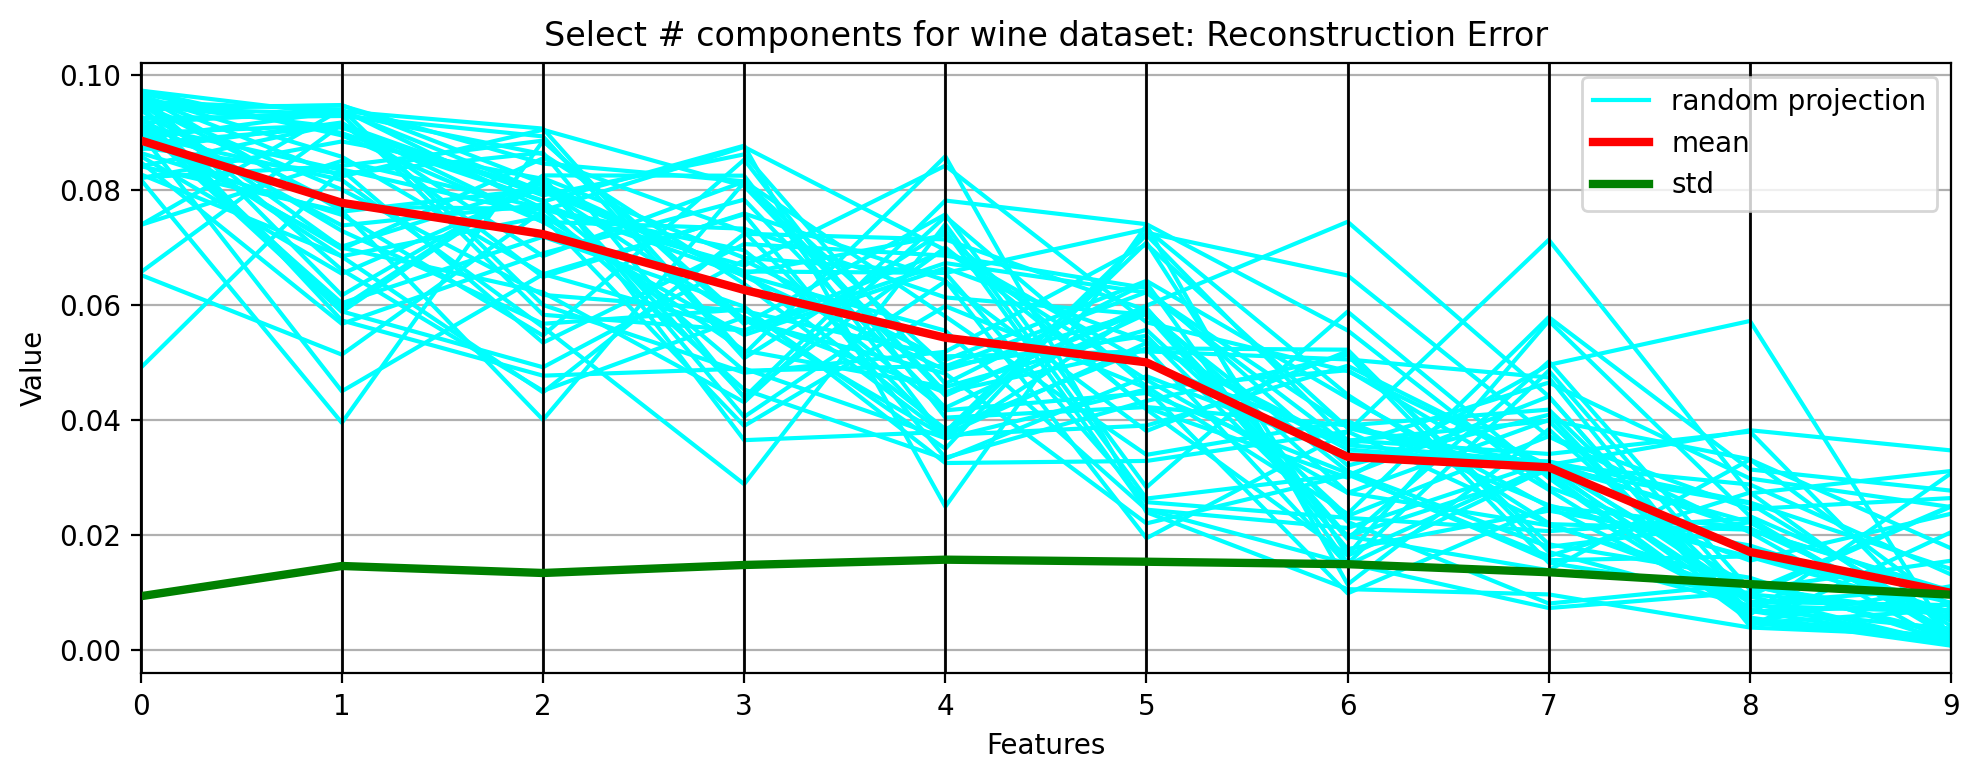

In [24]:
errors = []
for _ in range(50):
    tmp = random_project()
    errors.append(tmp)

df1 = pd.DataFrame(errors)
# df1['diagnosis'] = y1
df1['class'] = "random projection"
print(df1.head(5))

plt.figure(figsize=(10, 4), dpi=200)
pd.plotting.parallel_coordinates(df1,'class', colormap='cool')
plt.plot(df1.mean(axis=0), label='mean', color='r', linewidth=3)
plt.plot(df1.std(axis=0), label='std', color='g', linewidth=3)
# plt.xticks(rotation=30)
plt.xlabel('Features')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Select # components for wine dataset: Reconstruction Error')
plt.tight_layout()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\rca_wine_error.png', dpi=300)

Misclassified samples: 189
SVM Kernel train/test accuracy: 0.722/0.730


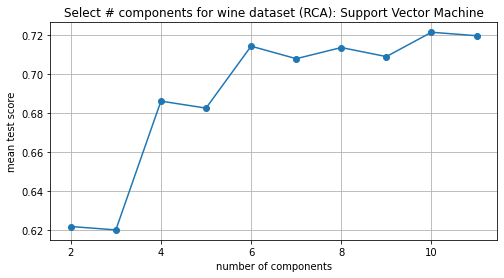

In [13]:
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

######
# Run Grid Search to find optimal components
######
# import packages
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

SEED = 77
# preprocessing: scaling the data and split dataset
data = pd.read_csv("../winequality.csv")
predictors = data[data.columns.difference(["label"])]

target = data[["label"]].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=0.8, random_state=SEED, stratify=target)
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_toTransform = X_train_std
y_train = y_train
y_test = y_test

# Define the classifier
svm = SVC(random_state=1, kernel='linear', gamma=0.1, C=10)
pipe = Pipeline([
    ('reduce_dim', GaussianRandomProjection())
     ,('classify', svm)
])
N_FEATURES_OPTIONS = range(2,12)
parameters = {  'reduce_dim__n_components':N_FEATURES_OPTIONS,
             }
clf = GridSearchCV(pipe, cv=5, param_grid=parameters, n_jobs=-1)

# Run the classifier
clf.fit(X_train_std, y_train)

# Identify training and test accuracy
y_pred = clf.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('SVM Kernel train/test accuracy: %.3f/%.3f' % (train_accuracy, test_accuracy))

mean_scores = np.array(clf.cv_results_['mean_test_score'])

mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (1 + 1) + .5)

scores = [x for x in clf.cv_results_['mean_test_score']]

plt.figure(figsize=(8,4))
plt.plot(N_FEATURES_OPTIONS, scores,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('mean test score')
plt.title('Select # components for wine dataset (RCA): Support Vector Machine')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\rca_wine_svm.png', dpi=300)
plt.show()